<a href="https://colab.research.google.com/github/davibuss/Homework2-Caltech101/blob/master/Copy_of_Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip install imutils

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


**Import libraries**

In [1]:
import os
import logging
import os.path
import sys
import re
import cv2
import numpy as np

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 100     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 90       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [103]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
print(type(train_dataset))

"""
train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)

"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]
print(train_indexes)
print(val_indexes)
print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)


val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


<class 'Caltech101.caltech_dataset.Caltech'>
[3249, 2705, 2563, 5560, 3607, 3586, 2192, 1258, 1965, 5166, 3827, 1600, 1986, 1308, 2152, 2768, 876, 1141, 769, 5634, 2846, 3546, 639, 4042, 413, 5533, 4799, 214, 2762, 4241, 4522, 4450, 3854, 5078, 755, 4617, 188, 863, 4420, 5654, 2086, 1982, 5044, 4360, 5203, 2325, 1012, 5333, 4598, 2170, 4892, 4796, 5435, 6, 4174, 1074, 2619, 2931, 5413, 1697, 3843, 952, 2227, 948, 4668, 238, 5450, 2037, 2926, 3009, 1811, 5601, 3322, 2753, 2128, 5553, 4806, 75, 42, 3075, 28, 5116, 447, 2133, 5065, 2882, 298, 2829, 209, 1551, 901, 1328, 3751, 3798, 1223, 4052, 2191, 2925, 2421, 5709, 1363, 2979, 4169, 886, 5339, 1884, 268, 3325, 2290, 1711, 2646, 429, 3876, 5603, 469, 1383, 3984, 4215, 3193, 5584, 185, 3320, 3721, 1815, 358, 1723, 205, 2901, 5147, 1378, 3755, 3398, 3525, 3674, 2009, 1435, 1781, 5237, 4495, 4033, 4721, 1109, 4630, 433, 3220, 2326, 2725, 224, 4475, 1298, 2779, 1036, 1369, 3399, 4203, 2787, 4415, 524, 5370, 1429, 3633, 31, 810, 3520, 718, 33

In [0]:
train_classes = np.zeros(101)

for elem in train_dataset:
  train_classes[elem[1]] += 1

val_classes = np.zeros(101)

for elem in val_dataset:
  val_classes[elem[1]] += 1

[ 18. 267.  11.  11.  16.  24.  20.  13.  42.  29.  14.  35.  26.  13.
  14.  40.  15.  19.  22.  41.  19.  25.  23.  22.  17.  12.  19.  22.
  17.  28.  25.  19.  16.  17.  24.  28. 142. 157.  26.  25.  21.  10.
  12.  19.  31.  34.  14.  19.  33.  19.  11.  23.  33.  37.  16.  28.
  69.  29.  12.  28.  15.  12.  28.  12.  25. 235.  14.  11.  15.  17.
  15.  14.  14.  13.  20.  27.  20.  17.  13.  22.  15.  28.  20.  14.
  20.  15.  24.  20.  28.  10.  28.  17.  24.  25.  79.  10.  20.  13.
  17.  16.  19.]


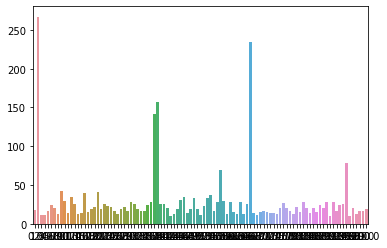

In [25]:
print(train_classes)
ax = sns.barplot(x=np.linspace(0, 100, num=101), y=train_classes)

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [107]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/100, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.623844146728516
Step 10, Loss 4.623544216156006
Starting epoch 2/100, LR = [0.001]
Step 20, Loss 4.619775772094727
Starting epoch 3/100, LR = [0.001]
Step 30, Loss 4.617133140563965
Starting epoch 4/100, LR = [0.001]
Step 40, Loss 4.61474609375
Starting epoch 5/100, LR = [0.001]
Step 50, Loss 4.61157751083374
Starting epoch 6/100, LR = [0.001]
Step 60, Loss 4.608094215393066
Starting epoch 7/100, LR = [0.001]
Step 70, Loss 4.604264736175537
Starting epoch 8/100, LR = [0.001]
Step 80, Loss 4.6015214920043945
Starting epoch 9/100, LR = [0.001]
Step 90, Loss 4.599964141845703
Starting epoch 10/100, LR = [0.001]
Step 100, Loss 4.602491855621338
Starting epoch 11/100, LR = [0.001]
Step 110, Loss 4.591472625732422
Step 120, Loss 4.58869743347168
Starting epoch 12/100, LR = [0.001]
Step 130, Loss 4.590440273284912
Starting epoch 13/100, LR = [0.001]
Step 140, Loss 4.576876163482666
Starting epoch 14/100, LR = [0.001]
Step 150, Loss 4.582828521728516
Starting epoch 15/100, LR = 

**Validation**

In [108]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

Validation Accuracy: 0.25138312586445366


**Test**

In [109]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

Test Accuracy: 0.24403733148980297
